# Exercise 3

In this exercise you will extend the Tensor class by
- additional activation functions
- tensor contraction with the einsum (Einstein summation).
For both, you will write both forward and backward pass and derive their derivatives.

## Additional activation functions

### GeLU

The Gaussian error linear unit (GeLU) is defined as

$$ \text{GeLU}(x) = x \cdot P( X \leq x) $$

where $ X \sim \mathcal{N}(0,1) $ is normally distributed and $P(X \leq x)$ is the cumulative distribution function (CDF) of the standard normal distribution. 
For implementation, you can use the Gaussian error function defined as

$$
\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} \, dt
$$

- Derive (submit as PDF) the derivative of the GeLU function.
- Implement GeLU in the Tensor class provided below. Use the error function in the math module. Hint: Use the fundamental theorem of calculus


### Leaky ReLU

The Leaky Rectified Linear Unit (Leaky ReLU) is defined as:

$$
\text{Leaky ReLU}(x) = \begin{cases} 
x & \text{if } x \geq 0 \\
\alpha x & \text{if } x < 0 
\end{cases}
$$

where \( $\alpha$ \) is a small constant (typically \( $\alpha$ = 0.01 \)) that determines the slope of the function for negative inputs.

- Derive (submit as PDF) the derivative of the Leaky ReLU function.
- Implement leaky ReLU in the Tensor class provided below. Use the error function in the math module.


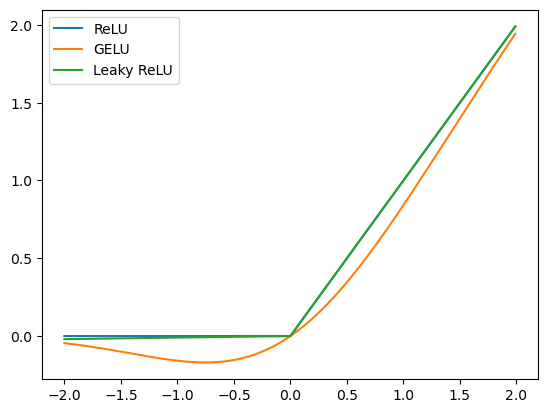

In [2]:
# Visualizations

import numpy as np
import math
import matplotlib.pyplot as plt

x = np.arange(-2,2,0.01)
y_relu = np.maximum(0,x)
y_gelu = x * 0.5 * (1 + np.array([math.erf(i/math.sqrt(2)) for i in x]))
y_leaky_relu = np.maximum(0.01*x,x)

plt.plot(x,y_relu,label='ReLU')
plt.plot(x,y_gelu,label='GELU')
plt.plot(x,y_leaky_relu,label='Leaky ReLU')
plt.legend()


# Tensor contraction with einsum (Einstein summation)

The einsum method is a general approach to arbitrary size tensor operations (including matrix multiplication and various contractions).
We will implement einsum for the contraction of two tensors $A \in \mathbb{E}^{n_1 \times \ldots \times n_{d_1}}$ and $B \in \mathbb{E}^{m_1 \times \ldots \times m_{d_1}}$. 
Let us denote by $I$ a set of summation indices.
Let us denote by `u`, `v` and `w` three strings that contain at most one of each summation indices. Then an einsum operation is given by a string 
`C = einsum(u,v->w,A,B)` that multiples $A$ and $B$ according to the indices in `u` and `w` and then contracts for all the indices not present in `w`. 
For example, we get

- Scalar product: If we have two vectors $a,b \in \mathbb{R}^n$ we can get $\langle a, b \rangle$ by `np.einsum("i,i->", a, b)`.
- Elementwise multiplication: If we have two vectors $a,b \in \mathbb{R}^n$ we can get $a * b$, the elementwise multiplication, by `np.einsum("i,i->i", a, b)`.
- Matrix-vector multiplication: If we are given a matrix $A \in \mathbb{R}^{n \times m}$ and a vector $x \in \mathbb{R}^m$ we can obtain matrix multiplication $Ax$ by `np.einsum("ij,j->i",A,x)`.
- Matrix-multiplication: If we have two matrices $A \in \mathbb{R}^{n \times m}$ and $B \in \mathbb{R}^{m \times k}$ we can get $C = A \cdot B$ by `np.einsum("ij,jk->ik", A, B)`
- Transpose: Given a matrix $A \in \mathbb{R}^{n \times m}$ we can get its transpose $A^{\top}$ by `np.einsum("ij->ji",A)`.

See [here](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) for the numpy implementation.
See additionally [here](https://rockt.github.io/2018/04/30/einsum) for a more detailed intro to einsum.

- Prove that the derivative of the einsum operation is $\nabla_A$`einsum(u,v->w)`$ = $`einsum(v,w->u,B,C)` and $\nabla_B$`einsum(u,v->w)`$ = $`einsum(u,w->v,A,C)`.
- Implement the forward and backward pass of the einsum operation in the Tensor class provided below.



In [ ]:
class Tensor:

    def __init__(self, data=None, shape=None, children: set=(), operation="", label=None, requires_grad=True):
        assert data is not None or shape is not None
        assert data is None or shape is None

        if data is not None:
            if isinstance(data, list):
                self.data = np.array(data, dtype=float)
            elif isinstance(data, (int, float, list)):
                self.data = np.array(data, dtype=float)
            else:
                assert isinstance(data, np.ndarray)
                self.data = data
        else:
            self.data = np.zeros(shape)
        self._requires_grad = requires_grad
        self._backward = lambda: None
        self._prev = set(children)
        self._operation = operation
        self._label = label
        if self._requires_grad:
            self.grad = np.zeros_like(self.data)
        else:
            self.grad = None

    def __repr__(self):
        return f"Tensor(data={self.data})"

    def __matmul__(self, other):
        other = Tensor(data=other) if not isinstance(other, Tensor) else other
        #out_data = self.data @ other.data
        if len(self.data.shape) == 1 and len(other.data.shape) == 1:
            return self.einsum("i,i->", other)
        if len(self.data.shape) == 2 and len(other.data.shape) == 1:
            return self.einsum("ij,j->i", other)
        if len(self.data.shape) == 1 and len(other.data.shape) == 2:
            return self.einsum("i,ij->j", other)
        if len(self.data.shape) == 2 and len(other.data.shape) == 2:
            return self.einsum("ij,jk->ik", other)

    def scalar_mul(self, scalar):
        out_data = scalar * self.data
        out = Tensor(data=out_data, children=(self,), requires_grad=self._requires_grad)

        def _backward():
            self.grad += scalar * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        if isinstance(other, (int, float)):
            return self.scalar_mul(other)

        if isinstance(other, np.ndarray):
            other = Tensor(data=other.astype(np.float))
        else:
            assert isinstance(other, Tensor)

        other = Tensor(data=other) if not isinstance(other, Tensor) else other
        out_data = self.data * other.data
        out = Tensor(data=out_data, children=(self, other), requires_grad=self._requires_grad)

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = Tensor(data=(other * np.ones(self.data.shape)))
        elif isinstance(other, np.ndarray):
            other = Tensor(data=other.astype(np.float))
        else:
            assert isinstance(other, Tensor)

        out_data = self.data + other.data
        out = Tensor(data=out_data, children=(self, other), requires_grad=self._requires_grad)

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        ones_data = Tensor(data = -np.ones(self.shape))
        return self * ones_data

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def __pow__(self, exponent):
        assert isinstance(exponent, (int, float)), "Only int/float can be used"
        out_data = self.data ** exponent
        out = Tensor(data=out_data, children=(self,), requires_grad=self._requires_grad)

        def _backward():
            self.grad += exponent * (self.data ** (exponent - 1)) * out.grad.data
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Tensor(data=t, children=(self,), operation="tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out_data = np.maximum(0.0, self.data)
        out = Tensor(data=out_data, children=(self,), operation='ReLU')

        def _backward():
            self.grad += (self.data > 0) * out.grad
        out._backward = _backward
        return out

    def gelu(self):
        # element-wise error function * x
        out_data = np.vectorize(lambda x: x * 0.5 * (1 + math.erf(x / math.sqrt(2))))(self.data)
        out = Tensor(data=out_data, children=(self,), operation='GeLU')

        def _backward():
            self.grad += out.grad * \
                (out_data + 1/np.sqrt(2 * np.pi) * self.data * np.exp(-0.5 * self.data ** 2))
        return out

    def leaky_relu(self):
        alpha = 0.01
        # if x >= 0: x else: alpha * x
        out_data = ((self.data < 0) * (alpha - 1) + 1)* self.data
        out = Tensor(data=out_data, children=(self,), operation='Leaky ReLU')

        def _backward():
            # if x >= 0: 1 else: alpha
            self.grad += out.grad * ((self.data < 0)*(alpha - 1) + 1)

        out._backward = _backward
        return out

    def einsum(self, string, *tensors):
        assert len(tensors) <= 1, "At most two tensors supported"

        if len(tensors) == 0:
            out_data = np.einsum(string, self.data)
            out = Tensor(data=out_data, children=(self,), operation=f"einsum({string})")
            return out

        if len(tensors) == 1:
            other = tensors[0]
            out_data = np.einsum(string, self.data, other.data)
            out = Tensor(data=out_data, children=(self, other), operation=f"einsum({string})")
            u, v, w = string.replace("->",",").split(",")

            def _backward():
                self.grad += np.einsum(f"{w},{v}->{u}", out.grad, other.data)
                other.grad += np.einsum(f"{u},{w}->{v}", self.data, out.grad)

            out._backward = _backward
            return out

    @property
    def T(self):
        return self.einsum("ij->ji")

    # The main backward method
    def backward(self):
        assert self.data.shape == (1,) or self.data.shape == ()
        self.grad = np.ones_like(self.data)
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = np.ones_like(self.data)
        for node in reversed(topo):
            node._backward()

In [4]:
from graphviz import Digraph

""" JUST ADDING THE .grad TO THE VISUALIZATION"""
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_node_label(tensor):
  l = ""
  assert len(tensor.shape) == 0 or len(tensor.shape) == 1 or len(tensor.shape) == 2
  if len(tensor.shape) == 0:
    return f'{tensor.item():.2f}'
  elif len(tensor.shape) == 1:
    return " ".join([f'{tensor.data[i]:.2f}' for i in range(tensor.shape[0])])
  else:
    for i in range(tensor.shape[0]):
      l += " ".join([f'{tensor.data[i, j]:.2f}' for j in range(tensor.shape[1])]) + "\\n"
    return l

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    label = '{' + f' {n._label} | ' + draw_node_label(n.data) + " | " + draw_node_label(n.grad) + '}'
    dot.node(name = uid, label = label, shape='record')
    if n._operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operation, label = n._operation)
      # and connect this node to it
      dot.edge(uid + n._operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

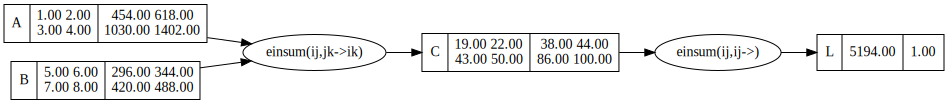

In [5]:
A = Tensor(data=[[1,2],[3,4]], label='A')
B = Tensor(data=[[5,6],[7,8]], label='B')
C = A @ B
C._label = 'C'
# C.grad = np.ones_like(C.data)

L = C.einsum("ij,ij->", C)
L._label = 'L'
L.backward()
draw_dot(L)

In [6]:
A_grad = C.grad @ B.data.transpose()
A_grad

array([[ 454.,  618.],
       [1030., 1402.]])

In [7]:
B_grad = A.data.transpose() @ C.grad
B_grad

array([[296., 344.],
       [420., 488.]])